In [87]:
import os
from os.path import basename,dirname
import glob
import numpy as np
import pandas as pd
import geopandas as gpd

import flopy

import matplotlib.pyplot as plt
# import plotly #allows interactive plotting
# import contextily as ctx # back ground maps

# import rasterio
import shapely
from shapely.ops import linemerge
from shapely.geometry import LineString, Point, shape, mapping
import fiona


In [15]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

In [205]:
sfr_dir = gwfm_dir+'SFR_data/'

# Stream XS data

In [53]:
df = pd.read_csv(dat_dir+'instream_sensor_latlong.csv')
df['id_num'] = df.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm = df[df.Type=='Level']
rm_sp = gpd.GeoDataFrame(rm, geometry=gpd.points_from_xy(rm.Longitude,rm.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

rm_xs = rm_sp[rm_sp.id_num>3]


In [73]:
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')

# pivot based on XS number and save only elevation in z_m

xs_all_df = pd.read_csv(dat_dir+'Elevation_by_XS_number_meters.csv',index_col=0)


<AxesSubplot:>

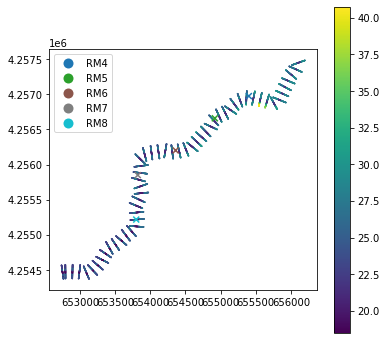

In [71]:
fig, ax =plt.subplots(figsize=(6,6))
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
# ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


xs_all.plot('z_m', markersize=0.2,legend=True,ax=ax,alpha=0.7)

rm_xs.plot('Sensor',ax=ax,legend=True,marker='x')


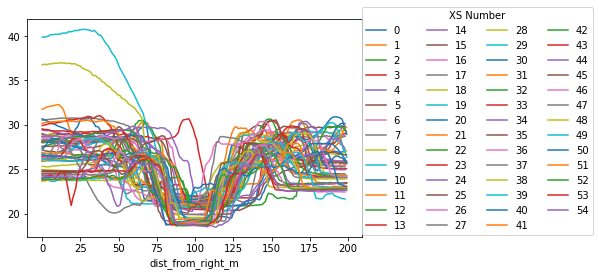

In [74]:
xs_all_df.plot()
plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


# Model DIS
The transects were created every 100 m traveling down the NHD streamline. Model discretization should be 100 m with a new segment every 100m for 54 segments. The cross-sections have a transverse length of 200m.

In [610]:
# xs_all_df
nrow=1
ncol = xs_all_df.columns.shape[0]
nlay=1

delr = 100 #longitudinal
delc= 200 # transverse
rotation=0

Need sub daily steps to capture passage of flow between gages in 15 minutes.

In [611]:
mb_15min = pd.read_csv(sfr_dir+'MB_15min_2010_10_01.csv',index_col='Datetime',parse_dates=['Datetime'])
# mb_15min = mb_15min[end_date:strt_date]

<AxesSubplot:xlabel='Datetime'>

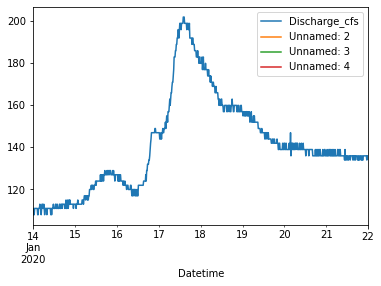

In [612]:
# Transient -> might want to think about making SP1 steady
end_date = pd.to_datetime('2020-01-22')
strt_date = pd.to_datetime('2020-01-14')

mb_15min_sim = mb_15min[strt_date:end_date]
# mb_15min_sim.index
mb_15min_sim.plot()

In [613]:
# 15 minute stress periods with 5 min steps?

dates = pd.date_range(strt_date, end_date, freq = '15min')

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()

# Reduce the number of timesteps to decrease run time
# 5 minute timessteps
nstp = np.append(np.ones(1),3*np.ones(nper-1))

In [614]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)


model_ws = proj_dir+'data'
# save data to Box because model run size will be small
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mfnwt', 
                          version = 'mfnwt', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 2, # in minutes because of SFR
                               rotation=rotation, 
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [615]:
# write modelgrid to get updated row and col numbers specific to the child grid
# m.modelgrid.write_shapefile(gwfm_dir+'/DIS_data/streambed_seepage/1D_grid/1D_grid.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/1D_grid/1D_grid.shp')
# grid_p.crs = 'epsg:32610'
# convert to 0 based
grid_p[['node','row','column']] -=1

In [664]:
top = np.reshape(xs_all.dissolve('xs_num','max').z_m.values, (nrow,ncol))

bot = top - 20 # interested in unsaturated zone (~20m, 65 ft thick)
bot[0,:] = pd.Series(bot[0,:]).rolling(5, center=True).mean().ffill().bfill().values


m.dis.top = top
m.dis.botm = bot

# SFR

In [616]:
# create summary of XS for creating SFR inputs
XSg = xs_all.dissolve('xs_num', 'mean')
XSg['iseg'] = XSg.index+1 # add the segment that corresponds to each cross section

In [660]:
# There is one reach for each cell that a river crosses
NSTRM = -len(XSg)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 60 # mannings constant for SI units, 1.0 for seconds, 86400 for days, 60 for minutes
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 5
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*60


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [661]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [662]:
# xs_sfr = grid_sfr.set_index('reach')
# # set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
# xs_sfr['iseg'] = 1
# # add a column reach_new that will be changed iteratively as the segment number is changed
# xs_sfr['reach_new'] = xs_sfr.index
# # xs_sfr

XSg['reach'] = 1
XSg['column'] = XSg.index
XSg['row'] = 0
XSg['layer'] = 0

XSg['node'] = grid_p.set_index(['row','column']).loc[list(zip(XSg.row,XSg.column))].node.values


<AxesSubplot:xlabel='xs_num'>

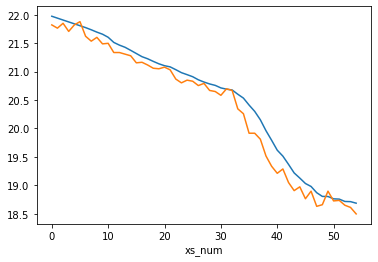

In [665]:
# find minimum value in XS related to thalweg
XSg['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg['z_m_min_cln'] = xs_z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg.z_m_min_cln.diff().bfill()
XSg['slope'] = z_cln_diff.abs()/delr

# fix str bot so all is downward sloping
for i in np.arange(len(XSg)-1,-1,-1):
#     if XSg.z_m.values[i] >= XSg.z_m.values[i-1]:
#         XSg.z_m_min.values[i] = XSg.z_m_min.values[i-1] - XSg.slope.values[i]*delc
# fill NAs due to rolling mean
    if XSg.z_m_min_cln.isna()[i]:
        XSg.z_m_min_cln.values[i] = XSg.z_m_min_cln.values[i + 1] + XSg.slope.values[i]*delr

        
# plot, large spike in top elevation causes discontinuity
# plt.plot(m.dis.top.array[0,:])
# plt.plot(m.dis.botm.array[0,0,:])

XSg.z_m_min_cln.plot()
XSg.z_m_min.plot()
# XSg.slope.plot(secondary_y = True)

In [666]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = XSg.node
sfr.reach_data.k = XSg.layer.astype(int)
sfr.reach_data.i = XSg.row
sfr.reach_data.j = XSg.column
sfr.reach_data.iseg = XSg.iseg
sfr.reach_data.ireach = XSg.reach
sfr.reach_data.rchlen = delr
sfr.reach_data.strtop = XSg.z_m_min_cln
sfr.reach_data.slope = XSg.slope
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = 1

sfr.reach_data.strhc1 = 10 # start with low conductivity 10 m/day (sandy muddish)

# UZF parameters
sfr.reach_data.thts = 0.25
sfr.reach_data.thti = 0.15 # partially saturated initially
sfr.reach_data.eps = 3
sfr.reach_data.uhc = 10


In [667]:
# sfr.check()

In [668]:
mb4rl = pd.read_csv(sfr_dir+'/michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


In [669]:

sfr_seg = sfr.segment_data[0].copy()

sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
# sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion


In [670]:
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*60. # m3/min, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [671]:
sfr.segment_data[0] = sfr_seg

In [672]:
# Pull out data for upstream and downstream reach of each segment
# up_data = xs_sfr.drop_duplicates('iseg')
# dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = 10
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = XSg.z_m_min_cln.values
sfr.segment_data[0].width1 = 100
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.25
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 3
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = 10
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = XSg.z_m_min_cln.values
sfr.segment_data[0].width2 = 100
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.25
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 3
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [673]:
print('NA with elev at 199: ', xs_all_df.isna().sum().sum(), '. NA without 199: ',xs_all_df.iloc[:-1].isna().sum().sum())
# Shanafield said that you can have more than 8 pts in a XS
XS8pt = xs_all_df.iloc[:-1]

NA with elev at 199:  23 . NA without 199:  0


Need to reduce to 8 point XS for method as is or pre - calculate flow, depth and width relation with mannings which may be better since I can decide when to use different mannings n  
GWF2SFR7FLW - 8-point cross-section module

In [674]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(1,len(XSg)+1)}  }

xsnum = 1
for k in XSg.index:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt[k].index
        ZCPT = XS8pt[k].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [675]:
# FLOWTAB = mb4rl.discharge_va.values
# DPTHTAB = mb4rl.gage_height_va.values
# WDTHTAB = mb4rl.chan_width.values
# sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [676]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
# inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)
# filter out data between the stress period dates
# inflow = inflow.loc[strt_date:end_date]

# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmm'] = mb_15min_sim.Discharge_cfs * (60/(3.28**3))

# # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(1,len(inflow.flow_cmm)+1),inflow.flow_cmm))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
time_flow = np.row_stack(([0, inflow.flow_cmm.median()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [634]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

In [677]:
# sfr.check()
# sfr.write_file()

# Model discretization with SFR

In [636]:
ibound = np.ones((nlay,nrow,ncol))
# to maintain gw flow gradient that mimics ground surface slope shanafield used a CHD at up and down stream
ibound[:,:,0] = -1
ibound[:,:,-1] = -1

strt = np.reshape(XSg.z_m_min.values, (nrow,ncol))-5 # start heads below the stream bottom



In [637]:
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt, stoper = 0.01)

In [638]:
# may have to manually add since it seems to overwrite
# allows model to continue even if convergence fails
bas.options = bas.options +' NO_FAILED_CONVERGENCE_STOP'

In [639]:
hk = np.zeros(m.dis.botm.shape)
hk[:,:,:] = 10
vka = 1
sy = np.zeros(m.dis.botm.shape)
sy[:,:,:] = 0.2
ss = np.zeros(m.dis.botm.shape)
ss[:,:,:] = 1E-4


In [640]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 1

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
# laytyp = np.zeros(nlay)
# try making first 10 layers convertible/ unconfined, model crashes trying to convert wet/dry
num_unconf = 0
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
# gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
#             laytyp=laytyp, ipakcb=55)

gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, 
#                                ss = storativity, storagecoefficient=True, 
                               ss=ss, 
                               laytyp=laytyp, laywet = laywet, ipakcb=55)

# Gage outflow
Can set up files for each stream stage sensor or use the primary sfr/dfw out file

In [641]:
# sensors = pd.read_csv(gwfm_dir+'/Mapping/allsensor_latlong.csv')
# sensors = gpd.GeoDataFrame(sensors,geometry=gpd.points_from_xy(sensors.Longitude, sensors.Latitude))
# sensors.crs = 'epsg:4326'
# sensors = sensors.to_crs('epsg:32610')
# mcc_grid = gpd.sjoin(sensors[sensors.Site_id=='MCC'],xs_sfr)
# mcc_grid.columns

In [642]:
# numgage is total number of gages
# gage_data (list, or array), includes 2 to 3 entries (LAKE -UNIT (OUTTYPE)) for each LAK entry
#  4 entries (GAGESEG, GAGERCH, UNIT, OUTTYPE) for each SFR package entry

# mcc_gage_data = [[mcc_grid.iseg, mcc_grid.reach_new, 37, 1]]
# gage_file = 'MF.gage'
# mcc_file_out = 'MF_mcc.go' # not recognized still
# gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=mcc_gage_data,
#                                 filenames =[gage_file,mcc_file_out])


# Output and Solver 

In [643]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days

for j in month_intervals:
    spd[j,0] = ['save head','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [644]:
# Shanafield input for nWT
#  MODFLOW2005 NWT Input File

# HEADTOL FLUXTOL MAXITEROUT THICKFACT LINMETH IPRNWT IBOTAV OPTIONS [DBDTHETA] [DBDKAPPA] [DBDGAMMA] [MOMFACT] [BACKFLAG] [MAXBACKITER] [BACKTOL] [BACKREDUCE]
# 1.0E-3 0.01 5000 0.001  2  1 1 SPECIFIED 0.80 0.0001 0.000  0.10 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)     
#[IACL][NORDER][LEVEL][NORTH][IREDSYS][RRCTOLS][IDROPTOL][EPSRN] [HCLOSEXMD][MXITERXMD]
# 2 0 1 2 0 0.0 1 1 1.0E-3 7 1.0e-4      100 2  2  1.0e-9  20  4       XMD (faster results--6.7 seconds) 


# 1.0e-4 5.0e-4 500 0.001  2  1 1 0.70 0.0001 0.000  0.00 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)  
# 2 0 1 2 0 0.0 1 1 1.0E-3 7 1.0e-4     XMD (faster results--6.7 seconds)

#  MODFLOW2005 NWT Input File
# 1.0E-2 15.0 500 0.001  2  1 1 0.70 0.0001 0.000  0.00 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)  
# 2 0 8 2 0 0.0 1 1 1.0E-3 7 1.0e-4     XMD (faster results--6.7 seconds)

In [645]:
# the DFW model had units of meters and seconds
500/86400

0.005787037037037037

In [646]:
# nwt_ex

In [647]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified')
nwt_dict = nwt.__dict__
# nwt_dict
# nwt_dict['headtol'] = 1E-3
# nwt.__dict__ = nwt_dict
# nwt.__dict__
# nwt.write_file()

In [648]:
# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'First'].astype(nwt_ex.loc[v,'nwt_dtype'])

In [649]:
# update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

In [650]:
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)
# headtol/flux tol are in m/day
# solver = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
#                                linmeth=1, iprnwt=1, ibotav=0, options='SPECIFIED', Continue=True,
#                                maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
#                                levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
#                                iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
#                                mxiterxmd=50, extension='nwt', unitnumber=27)




In [651]:
m.get_package_list()

['DIS', 'SFR', 'DATA', 'BAS6', 'LPF', 'OC', 'NWT']

In [652]:
sfr.check()

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

No DIS package or SpatialReference object; cannot check reach proximities.

Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=55 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not specified for nstrm=55 and isfropt=1
passed.

Checking for streambed slopes of less than

In [653]:
m.write_input()